# First let's explore the model to understand what we have to build

In [1]:
from transformers import GPT2LMHeadModel #huggingface library

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/image.so
  Expected in: /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
 in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]


tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

# Test our Model

In [3]:
import gpt2
import torch
# Inizializza il modello e input fittizio
config = gpt2.GPT2Config()
model = gpt2.GPT2(config)

# Input: batch di 2 sequenze lunghe 10, token random tra 0 e vocab_size
x = torch.randint(0, config.vocab_size, (2, 10))

# Forward pass
logits = model(x)

print("Logits :", logits[0].shape) # (2, 10, vocab_size)


Logits : torch.Size([2, 10, 65])


## Toy Example

In [4]:
# Dizionario toy per esempio char-level
import string

# Caratteri validi (simile a quello usato nei mini GPT)
chars = string.ascii_lowercase + " .,!?'"  # 26 lettere + punteggiatura + spazio
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)

# Aggiorniamo la config per usare il vocab giusto
config.vocab_size = vocab_size
model = gpt2.GPT2(config)


In [5]:
def encode(text):
    return [stoi[c] for c in text if c in stoi]

def decode(tokens):
    return ''.join([itos[i] for i in tokens])


In [7]:
input_text = "hello my nam"
input_ids = encode(input_text)
x = torch.tensor([input_ids], dtype=torch.long)  # shape (1, T)

with torch.no_grad():
    logits = model(x)  # shape: (1, T, vocab_size)

# Estrai i logits dell'ultimo token
last_logits = logits[0][0, -1]  # shape: (vocab_size,)

# Prendi il token con la probabilità più alta
predicted_token_id = torch.argmax(last_logits).item()
predicted_char = itos[predicted_token_id]

print(f"Input: '{input_text}'")
print(f"Predicted next char: '{predicted_char}'")


Input: 'hello my nam'
Predicted next char: 'c'


## Let's train the model

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1 | Train: 0.7381 | Val: 0.0402 | Test: 0.0407
Model saved!
Epoch 2 | Train: 0.0207 | Val: 0.0142 | Test: 0.0148
Model saved!
Epoch 3 | Train: 0.0131 | Val: 0.0124 | Test: 0.0125
Model saved!
Epoch 4 | Train: 0.0118 | Val: 0.0113 | Test: 0.0118
Model saved!
Epoch 5 | Train: 0.0112 | Val: 0.0108 | Test: 0.0112
Model saved!


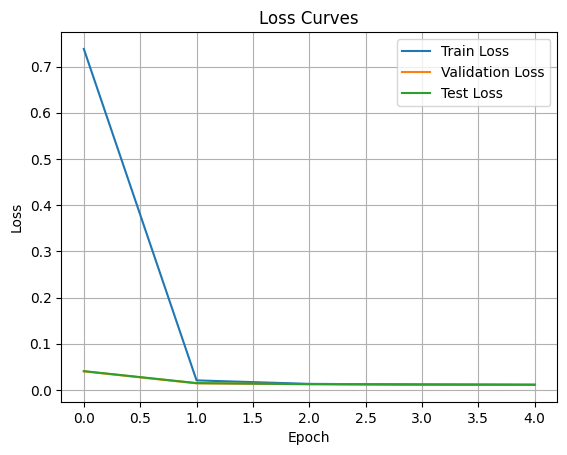

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import gpt2
import string
import matplotlib.pyplot as plt
import time
import os

# --- Config ---
BATCH_SIZE = 32
BLOCK_SIZE = 128
EPOCHS = 5
LR = 3e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = "best_model.pt"
PATIENCE = 2  # Early stopping patience

# --- Tokenizer ---
chars = string.ascii_lowercase + " .,!?\'"
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)
encode = lambda s: [stoi[c] for c in s if c in stoi]
decode = lambda l: ''.join([itos[i] for i in l])

# --- Text ---
text = "hello world! this is a mini gpt2 training test. " * 200
data = torch.tensor(encode(text), dtype=torch.long)

# --- Dataset ---
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + 1 + self.block_size] # next token prediction with a sliding window of block_size
        # It could be useful with a larger dataset to use a stride of 4 for example (to avoid overlapping)
        return x, y

full_dataset = CharDataset(data, BLOCK_SIZE)

# --- Split: 80/10/10 ---
n = len(full_dataset)
train_size = int(0.8 * n)
val_size = int(0.1 * n)
test_size = n - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# --- Model ---
config = gpt2.GPT2Config(
    vocab_size=vocab_size,
    block_size=BLOCK_SIZE,
    n_layer=4,
    n_head=4,
    n_embd=128,
)
model = gpt2.GPT2(config).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler()


# --- Training ---
train_losses, val_losses, test_losses = [], [], []
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.cuda.amp.autocast():
            # Forward pass
            logits = model(x)
            loss = F.cross_entropy(logits[0].view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad()
        scaler.scale(loss).backward() # we compute this in float16 (mixed precision) to save memory and time
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping -> smoother convergence (expecially in early epochs)
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    def evaluate(loader):
        total_loss = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                loss = F.cross_entropy(logits[0].view(-1, vocab_size), y.view(-1))
                total_loss += loss.item()
        return total_loss / len(loader)

    val_loss = evaluate(val_loader)
    test_loss = evaluate(test_loader)
    train_loss = total_train_loss / len(train_loader)

    print(f"Epoch {epoch+1} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Test: {test_loss:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping.")
            break

# --- Plotting losses ---
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.grid(True)
plt.show()


## Inference time

In [8]:
import torch
import torch.nn.functional as F
import ipywidgets as widgets
from IPython.display import display, clear_output

# Put model in eval mode & on the right device
model.eval()
model.to(DEVICE)

# Optional: wrap inference in no_grad + autocast
@torch.no_grad()
def generate_text(prompt, max_new_tokens=200, temperature=1.0, top_k=40): # max_new_tokens can influence the time it takes to generate
    model.eval()
    # Encode the prompt into token IDs
    input_ids = torch.tensor([stoi[c] for c in prompt], dtype=torch.long)[None].to(DEVICE)

    for _ in range(max_new_tokens):
        if input_ids.size(1) >= config.block_size:
            input_ids = input_ids[:, -config.block_size:]

        with torch.cuda.amp.autocast():
            logits = model(input_ids)[0]
            logits = logits[:, -1, :] / temperature # scale logits by temperature to control randomness

            if top_k is not None:
                top_k = min(top_k, logits.size(-1))  # Ensure top_k doesn't exceed vocab size
                v, ix = torch.topk(logits, top_k) # get top_k logits to reduce the search space
                logits[logits < v[:, [-1]]] = -float("Inf")

            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1) # sample from the distribution -> more diverse, less deterministic
            # next_id = torch.argmax(probs, dim=-1) # greedy sampling
            input_ids = torch.cat((input_ids, next_id), dim=1)

        if itos[next_id.item()] == "\n":
            break

    out_text = ''.join([itos[i] for i in input_ids[0].tolist()])
    return out_text[len(prompt):]  # only return generated part


In [9]:
input_box = widgets.Text(
    placeholder='Say something...',
    description='You:',
    layout=widgets.Layout(width='80%')
)

output_box = widgets.Output()

def handle_input(sender):
    user_input = input_box.value
    input_box.value = ''  # clear input

    if not user_input.strip():
        return

    # Convert the user input to lowercase to match the training data (there is no handling for unseen characters!)
    user_input = user_input.lower()
    
    with output_box:
        print(f"You: {user_input}")
        response = generate_text(user_input, max_new_tokens=200, temperature=0.8, top_k=40)
        print(f"Bot: {response}")
        print("-" * 50)

input_box.on_submit(handle_input)

display(input_box)
display(output_box)


/var/folders/v8/mhxj6bfs2l3cpn1s0yq2lcl80000gn/T/ipykernel_2260/752712023.py:25: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(handle_input)


Text(value='', description='You:', layout=Layout(width='80%'), placeholder='Say something...')

Output()